In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import Word2Vec
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
import matplotlib.pyplot as plt

In [ ]:
path_to_json = 'full_format_recipes.json'
data = pd.read_json(path_to_json)

In [ ]:
# Descargamos recursos de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if isinstance(text, list):
        text = ' '.join(text)
    # Tokenización
    tokens = word_tokenize(text)
    # Convertimos a minúsculas y eliminar caracteres especiales
    tokens = [token.lower() for token in tokens if token.isalnum()]
    # Eliminamos números seguidos de un punto (ej. 1., 2.)
    tokens = [token for token in tokens if not re.match(r'^\d+\.$', token)]

    # Eliminamos stopwords
    tokens = [token for token in tokens if token not in stop_words]
    # Lematización
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens


#Reducimos la base de datos eliminando valores nulos
data.replace(r'^\s*$', np.nan, regex=True, inplace=True)  # Reemplazamos cadenas vacías por NaN
data_clean = data.dropna()

descripciones = data_clean['desc'].tolist()
print('Número de descripciones disponibles:', len(descripciones))

direcciones = data_clean['directions'].tolist()
print('Número de direcciones disponibles:', len(direcciones))


#Aplicamos el preprocesado de datos a las columnas de directions y desc
data_clean['desc_preprocessed'] =  [preprocess_text(desc) for desc in descripciones]
data_clean['dir_preprocessed'] =  [preprocess_text(direction) for direction in direcciones]




Número de descripciones disponibles: 10608
Número de direcciones disponibles: 10608


<ipython-input-5-6b75be1a75eb>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['desc_preprocessed'] =  [preprocess_text(desc) for desc in descripciones]
<ipython-input-5-6b75be1a75eb>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['dir_preprocessed'] =  [preprocess_text(direction) for direction in direcciones]


In [ ]:
dir_preprocessed = data_clean['dir_preprocessed'].tolist()
print(dir_preprocessed)

desc_preprocessed = data_clean['desc_preprocessed'].tolist()
print(desc_preprocessed)

In [ ]:
# Creamos el diccionario para los tokens de descriptions
D = gensim.corpora.Dictionary(dir_preprocessed)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])



The dictionary contains 6946 terms
First terms in the dictionary:
0 : 1
1 : 15
2 : 2
3 : 3
4 : 30
5 : 4
6 : 5
7 : 8
8 : 9
9 : add


In [ ]:

no_below = 10 #Numero minimo de veces que tiene que salir una palabra para meterlo al diccionario
no_above = .75 #Porcentaje maximo de veces que puede salir una palabra para meterlo al diccionario

D.filter_extremes(no_below=no_below, no_above=no_above, keep_n=25000)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(20):
    print(str(n), ':', D[n])

The dictionary contains 2314 terms
First terms in the dictionary:
0 : 1
1 : 15
2 : 2
3 : 3
4 : 30
5 : 4
6 : 5
7 : 8
8 : 9
9 : add
10 : ahead
11 : around
12 : arrange
13 : atop
14 : bake
15 : bay
16 : begin
17 : boiling
18 : bowl
19 : bread


In [ ]:
corpus_bow = [D.doc2bow(doc) for doc in dir_preprocessed]

In [ ]:
n_project = 1000
print("dir")
print(len(dir_preprocessed))
print(' '.join(dir_preprocessed[n_project]))
print('Sparse vector representation:')
print("corpus")
print(len(corpus_bow))
print(corpus_bow[n_project])
print('Word counts:')
print(list(map(lambda x: (D[x[0]], x[1]), corpus_bow[n_project])))


dir
10608
1 pour boiling water couscous salt cover let stand 10 minute using regular couscous soaking toss 1 tablespoon vegetable oil place colander steam boiling water stirring occasionally 20 minute stir fluff 2 stir sugar cinnamon butter pour couscous toss coat gradually add enough milk moisten couscous 3 mound couscous large platter sprinkle additional cinnamon individual serving pack custard cup invert onto serving plate add cup raisin cup chopped pitted date cup chopped dried apricot cup chopped blanched almond cup chopped walnut cup pine nut mounded couscous featured special occasion wedding bar mitzvah pack half couscous mixture large bowl sprinkle cup ground toasted blanched almond top remaining couscous invert onto serving platter sprinkle ground cinnamon garnish datils rellenos
Sparse vector representation:
corpus
10608
[(0, 2), (2, 1), (3, 1), (9, 2), (17, 2), (18, 1), (21, 1), (32, 1), (42, 1), (51, 2), (54, 1), (63, 1), (65, 1), (66, 1), (73, 1), (75, 2), (87, 1), (91, 1)

In [ ]:
#Representación de los tokens para DIRECTIONS
# SORTED TOKEN FREQUENCIES (I):
# Create a "flat" corpus with all tuples in a single list
corpus_bow_flat = [item for sublist in corpus_bow for item in sublist]

# Initialize a numpy array that we will use to count tokens.
# token_count[n] should store the number of ocurrences of the n-th token, D[n]
token_count = np.zeros(n_tokens)

# Count the number of occurrences of each token.
for x in corpus_bow_flat:
    # Update the proper element in token_count
    # scode: <FILL IN>
    token_count[x[0]] += x[1]

# Sort by decreasing number of occurences
ids_sorted = np.argsort(- token_count)
tf_sorted = token_count[ids_sorted]

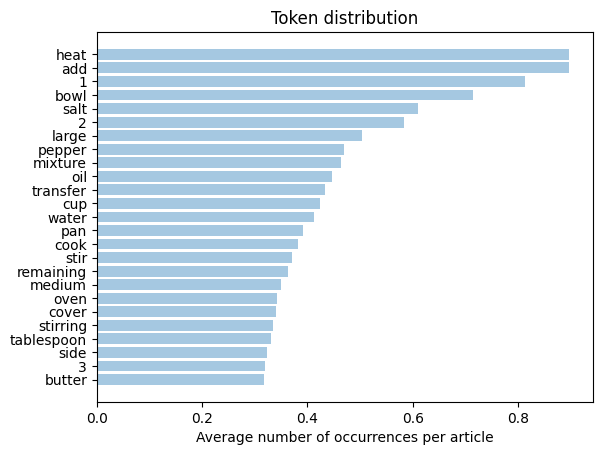

In [ ]:
# SORTED TOKEN FREQUENCIES (II):
plt.rcdefaults()

n_art = len(data)
n_bins = 25
hot_tokens = [D[i] for i in ids_sorted[n_bins-1::-1]]
y_pos = np.arange(len(hot_tokens))
z = tf_sorted[n_bins-1::-1]/n_art

plt.figure()
plt.barh(y_pos, z, align='center', alpha=0.4)
plt.yticks(y_pos, hot_tokens)
plt.xlabel('Average number of occurrences per article')
plt.title('Token distribution')
plt.show()

In [ ]:
# Vectorización TF-IDF
from gensim.models import TfidfModel
tfidf = TfidfModel(corpus_bow)
dir_tfidf = tfidf[corpus_bow]
print("dir_tfidf")
print(len(dir_tfidf))
data_clean['dir_tfidf'] = dir_tfidf
print(data_clean)
n_project = 1000
print(dir_tfidf[n_project])

dir_tfidf
10608
                                              directions   fat  \
1      [Combine first 9 ingredients in heavy medium s...  23.0   
5      [Mix basil, mayonnaise and butter in processor...  79.0   
8      [Stir together soy sauce, sugar, sesame oil, w...  10.0   
9      [Chop enough parsley leaves to measure 1 table...  41.0   
10     [Heat oil in heavy large skillet over medium-h...   5.0   
...                                                  ...   ...   
20121  [1. Preheat the oven to 400°F. Spray a baking ...  70.0   
20123  [Stir water, sugar and juice in saucepan over ...   0.0   
20126  [Bring broth to simmer in saucepan.Remove from...  28.0   
20128  [Heat 2 tablespoons oil in heavy medium skille...  24.0   
20129  [Position rack in bottom third of oven and pre...  10.0   

                           date  \
1     2004-08-20 04:00:00+00:00   
5     2004-08-20 04:00:00+00:00   
8     2004-08-20 04:00:00+00:00   
9     2008-10-23 22:24:26+00:00   
10    2004-08-20

<ipython-input-12-c5bcb2048f00>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['dir_tfidf'] = dir_tfidf


In [ ]:
#TF_IDF del campo desc
Ddesc = gensim.corpora.Dictionary(desc_preprocessed)
n_tokens = len(Ddesc)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', Ddesc[n])

Ddesc.filter_extremes(no_below=no_below, no_above=no_above, keep_n=25000)
n_tokens = len(Ddesc)
# </SOL>

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(20):
    print(str(n), ':', Ddesc[n])

desc_bow = [Ddesc.doc2bow(doc) for doc in desc_preprocessed]

tfidf_desc = TfidfModel(desc_bow)
desc_tfidf = tfidf_desc[desc_bow]
data_clean['desc_tfidf'] = desc_tfidf



The dictionary contains 12281 terms
First terms in the dictionary:
0 : blanc
1 : boudin
2 : classic
3 : day
4 : found
5 : french
6 : ingredient
7 : sausage
8 : serving
9 : start
The dictionary contains 2280 terms
First terms in the dictionary:
0 : blanc
1 : classic
2 : day
3 : found
4 : french
5 : ingredient
6 : sausage
7 : serving
8 : start
9 : two
10 : us
11 : white
12 : 45
13 : less
14 : minute
15 : prepared
16 : recipe
17 : elegant
18 : gently
19 : ham


<ipython-input-13-9eb222238bc0>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['desc_tfidf'] = desc_tfidf


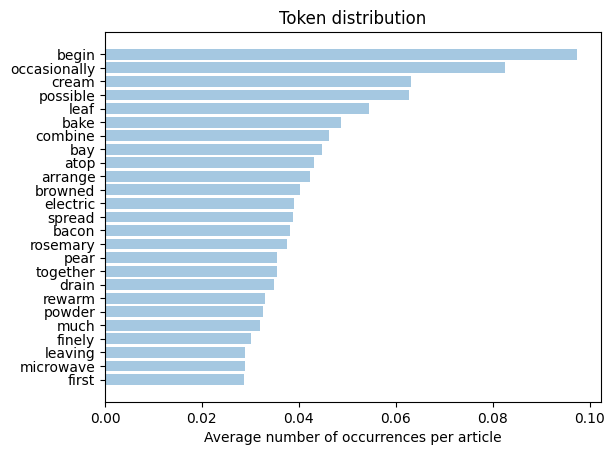

In [ ]:
#Representación de los tokens para DIRECTIONS
# SORTED TOKEN FREQUENCIES (I):
# Create a "flat" corpus with all tuples in a single list
corpus_bow_flat = [item for sublist in desc_bow for item in sublist]

# Initialize a numpy array that we will use to count tokens.
# token_count[n] should store the number of ocurrences of the n-th token, D[n]
token_count = np.zeros(n_tokens)

# Count the number of occurrences of each token.
for x in corpus_bow_flat:
    # Update the proper element in token_count

    token_count[x[0]] += x[1]

# Sort by decreasing number of occurences
ids_sorted = np.argsort(- token_count)
tf_sorted = token_count[ids_sorted]

# SORTED TOKEN FREQUENCIES (II):
plt.rcdefaults()

n_art = len(data)
n_bins = 25
hot_tokens = [D[i] for i in ids_sorted[n_bins-1::-1]]
y_pos = np.arange(len(hot_tokens))
z = tf_sorted[n_bins-1::-1]/n_art

plt.figure()
plt.barh(y_pos, z, align='center', alpha=0.4)
plt.yticks(y_pos, hot_tokens)
plt.xlabel('Average number of occurrences per article')
plt.title('Token distribution')
plt.show()

In [ ]:
#RANDOM-FOREST
from scipy.sparse import hstack
from gensim.matutils import corpus2csc

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix

# Seleccionamos las K mejores características del TF-IDF
selector = SelectKBest(f_regression, k=100)  # Selecciona 100 características más relevantes

x_data_dir = data_clean['dir_tfidf'].tolist()

# Convertimos TF-IDF corpus a una matriz dispersa (sparse matrix)

sparse_tfidf_matrix_dir = corpus2csc(x_data_dir).T  # Transponer porque corpus2csc devuelve palabras como filas
dense_tfidf_matrix_dir = sparse_tfidf_matrix_dir.toarray()

# Reducimos la dimensionalidad con PCA
pca = PCA(n_components=100)  # Reducir a 100 componentes principales
tfidf_reduced_dir = pca.fit_transform(dense_tfidf_matrix_dir)

x_data_desc = data_clean['desc_tfidf'].tolist()

# Convertimos TF-IDF corpus a una matriz dispersa (sparse matrix)
sparse_tfidf_matrix_desc = corpus2csc(x_data_desc).T  # Transponer porque corpus2csc devuelve palabras como filas
dense_tfidf_matrix_desc = sparse_tfidf_matrix_desc.toarray()

# Reducimos dimensionalidad con PCA
pca = PCA(n_components=100)  # Reducir a 100 componentes principales
tfidf_reduced_desc = pca.fit_transform(dense_tfidf_matrix_desc)

numerical_features = data_clean[['calories', 'protein', 'fat', 'sodium']].values


numerical_features_sparse = csr_matrix(numerical_features)
# Combinamos TF-IDF reducido con las columnas numéricas
x_data_combined = hstack([tfidf_reduced_dir,numerical_features_sparse])

from sklearn.preprocessing import MultiLabelBinarizer

# Convertimos las categorías en variables binarias
mlb = MultiLabelBinarizer()
categories_encoded = pd.DataFrame(
    mlb.fit_transform(data_clean['categories']),
    columns=mlb.classes_,
    index=data_clean.index
)

# Añadimos las categorías codificadas al DataFrame original
categories_sparse = csr_matrix(categories_encoded.values)

x_data_combined = hstack([x_data_combined, categories_sparse])



In [ ]:
#RANDOM-FOREST
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score as r2
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

np.random.seed(42)

# Obtenemos x_data (TF-IDF corpus) e y_data
y_data = data_clean['rating']


# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(x_data_combined, y_data, test_size=0.20, random_state=42)

# Dividimos el conjunto de entrenamiento en train_val y val
X_train_val, X_val, Y_train_val, Y_val = train_test_split(X_train, Y_train, test_size=0.30, random_state=42)

# Convertimos a matriz densa para usar con StandardScaler
X_train_val = X_train_val.toarray()
X_val = X_val.toarray()
X_test = X_test.toarray()

# Escalamos los datos
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Configuramos el modelo Random Forest y la búsqueda en cuadrícula
#rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [ 'None', 'sqrt']
}

#grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Entrenamos el modelo con la búsqueda de hiperparámetros
#grid_search.fit(X_train_val_scaled, Y_train_val)
#best_params = grid_search.best_params_

#print("Best parameters found:", best_params)

# Entrenamos el modelo con los mejores parámetros
model_original = RandomForestRegressor(
    n_estimators=500,
    max_depth=50,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42)
model_original.fit(X_train_val_scaled, Y_train_val)
Y_predict = model_original.predict(X_test_scaled)

# Evaluamos el modelo
MSE_original = mse(Y_test, Y_predict)
MAE_original = mae(Y_test, Y_predict)
R2_original = r2(Y_test, Y_predict)

print(f"MSE: {MSE_original}")
print(f"MAE: {MAE_original}")
print(f"R2: {R2_original}")

MSE: 1.2831556186137387
MAE: 0.7521528949998282
R2: 0.1939961107556858


In [ ]:
print("Best parameters found:", best_params)

Best parameters found: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import random


random_state = 10
# Fijamos las semillas para reproducibilidad
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(random_state)

# Definición del modelo
class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super(RegressionNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 25),
            nn.ReLU(),
            nn.Linear(25, 1)
        )
    def forward(self, x):
        return self.fc(x)


def NN_eval(X, y):
    # Estandarizamos los datos
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Convertimos a tensores
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    # Creamos DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Inicializamos modelo, función de pérdida y optimizador
    model = RegressionNN(input_dim=X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Entrenamiento
    for epoch in range(20):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}, Training Loss: {epoch_loss:.4f}")

    # Evaluación del modelo
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
        predictions = model(X_test_tensor)
        test_loss = criterion(predictions, y_test_tensor)
        print(f"Test loss: {test_loss.item()}")

        # Convertimos a NumPy y cálculo de R^2
        predictions_np = predictions.cpu().numpy()
        r2 = r2_score(y_test, predictions_np)
        print(f"R^2 Score: {r2:.4f}")

NN_eval(x_data_combined.toarray(), data_clean['rating'].tolist())


Epoch 1, Training Loss: 3857.4758
Epoch 2, Training Loss: 1619.9856
Epoch 3, Training Loss: 428.4239
Epoch 4, Training Loss: 348.3621
Epoch 5, Training Loss: 324.6328
Epoch 6, Training Loss: 309.2718
Epoch 7, Training Loss: 297.3664
Epoch 8, Training Loss: 286.6467
Epoch 9, Training Loss: 276.7164
Epoch 10, Training Loss: 267.9427
Epoch 11, Training Loss: 261.0296
Epoch 12, Training Loss: 252.4157
Epoch 13, Training Loss: 244.3835
Epoch 14, Training Loss: 237.4868
Epoch 15, Training Loss: 228.8851
Epoch 16, Training Loss: 221.5492
Epoch 17, Training Loss: 214.6377
Epoch 18, Training Loss: 206.2852
Epoch 19, Training Loss: 198.2943
Epoch 20, Training Loss: 191.3843
Test loss: 1.6049351692199707
R^2 Score: 0.0008
